<a href="https://colab.research.google.com/github/sudeep2711/FitSpark/blob/main/FitSpark_%7C_Main_Planner_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI Fitness Coach - Profile Analyzer Notebook Summary**

This Google Colab notebook serves as a prototype and testing ground for a key component of our AI Fitness Coach system: the LLM-based Profile Analyzer.

**Goal of This Notebook:**

The primary goal is to test and validate our ability to take raw, conversational user data (collected during the app's onboarding chat) and use a Large Language Model (LLM) like Google's Gemini to transform it into a clean, structured, and predictable JSON format.

This process is a crucial step in our agent-based architecture. Before we can generate a workout plan, we need a reliable way to understand the user's profile. This notebook proves we can achieve that understanding using an LLM.

**What the Code Does (Step-by-Step)**:


*   **Setup:** It installs the necessary Google AI Python library (google-generativeai) required to communicate with the Gemini API.

*   **API Key Configuration:** It securely configures your GEMINI_API_KEY from Colab's Secret Manager. This authenticates your requests to the Gemini service and is the first step to ensuring you can connect successfully.
* **Function Definitions (The "Tool"):**
build_analyzer_prompt: This function constructs a detailed set of instructions for the LLM. It defines the AI's role ("expert fitness data analyst"), provides the user's raw answers, and gives strict rules on how to classify the information and what the final JSON output must look like. This prompt is the "brain" of our analysis, guiding the LLM to give us exactly what we need.
analyze_user_profile_with_llm: This function is the "tool" itself. It takes the raw user data, calls build_analyzer_prompt to get the instructions, and then sends both to the Gemini API (gemini-1.5-flash model). A key feature here is setting the response_mime_type to application/json, which forces the LLM to return only structured data, making it reliable.

*  **Running the Test:** This final cell simulates the entire process.
It defines a sample_user_data dictionary, which represents the kind of raw data we'd get from our onboarding flow.
It calls our analyze_user_profile_with_llm function with this sample data.
Finally, it "pretty prints" the structured JSON response received from Gemini, allowing us to see the final, cleaned-up user profile.

Detailed documentation:
https://docs.google.com/document/d/1HXd_peLyUWUMTvyzoYGPpzOn6VIqte4EJuhqpxfG8Tk/edit?tab=t.0

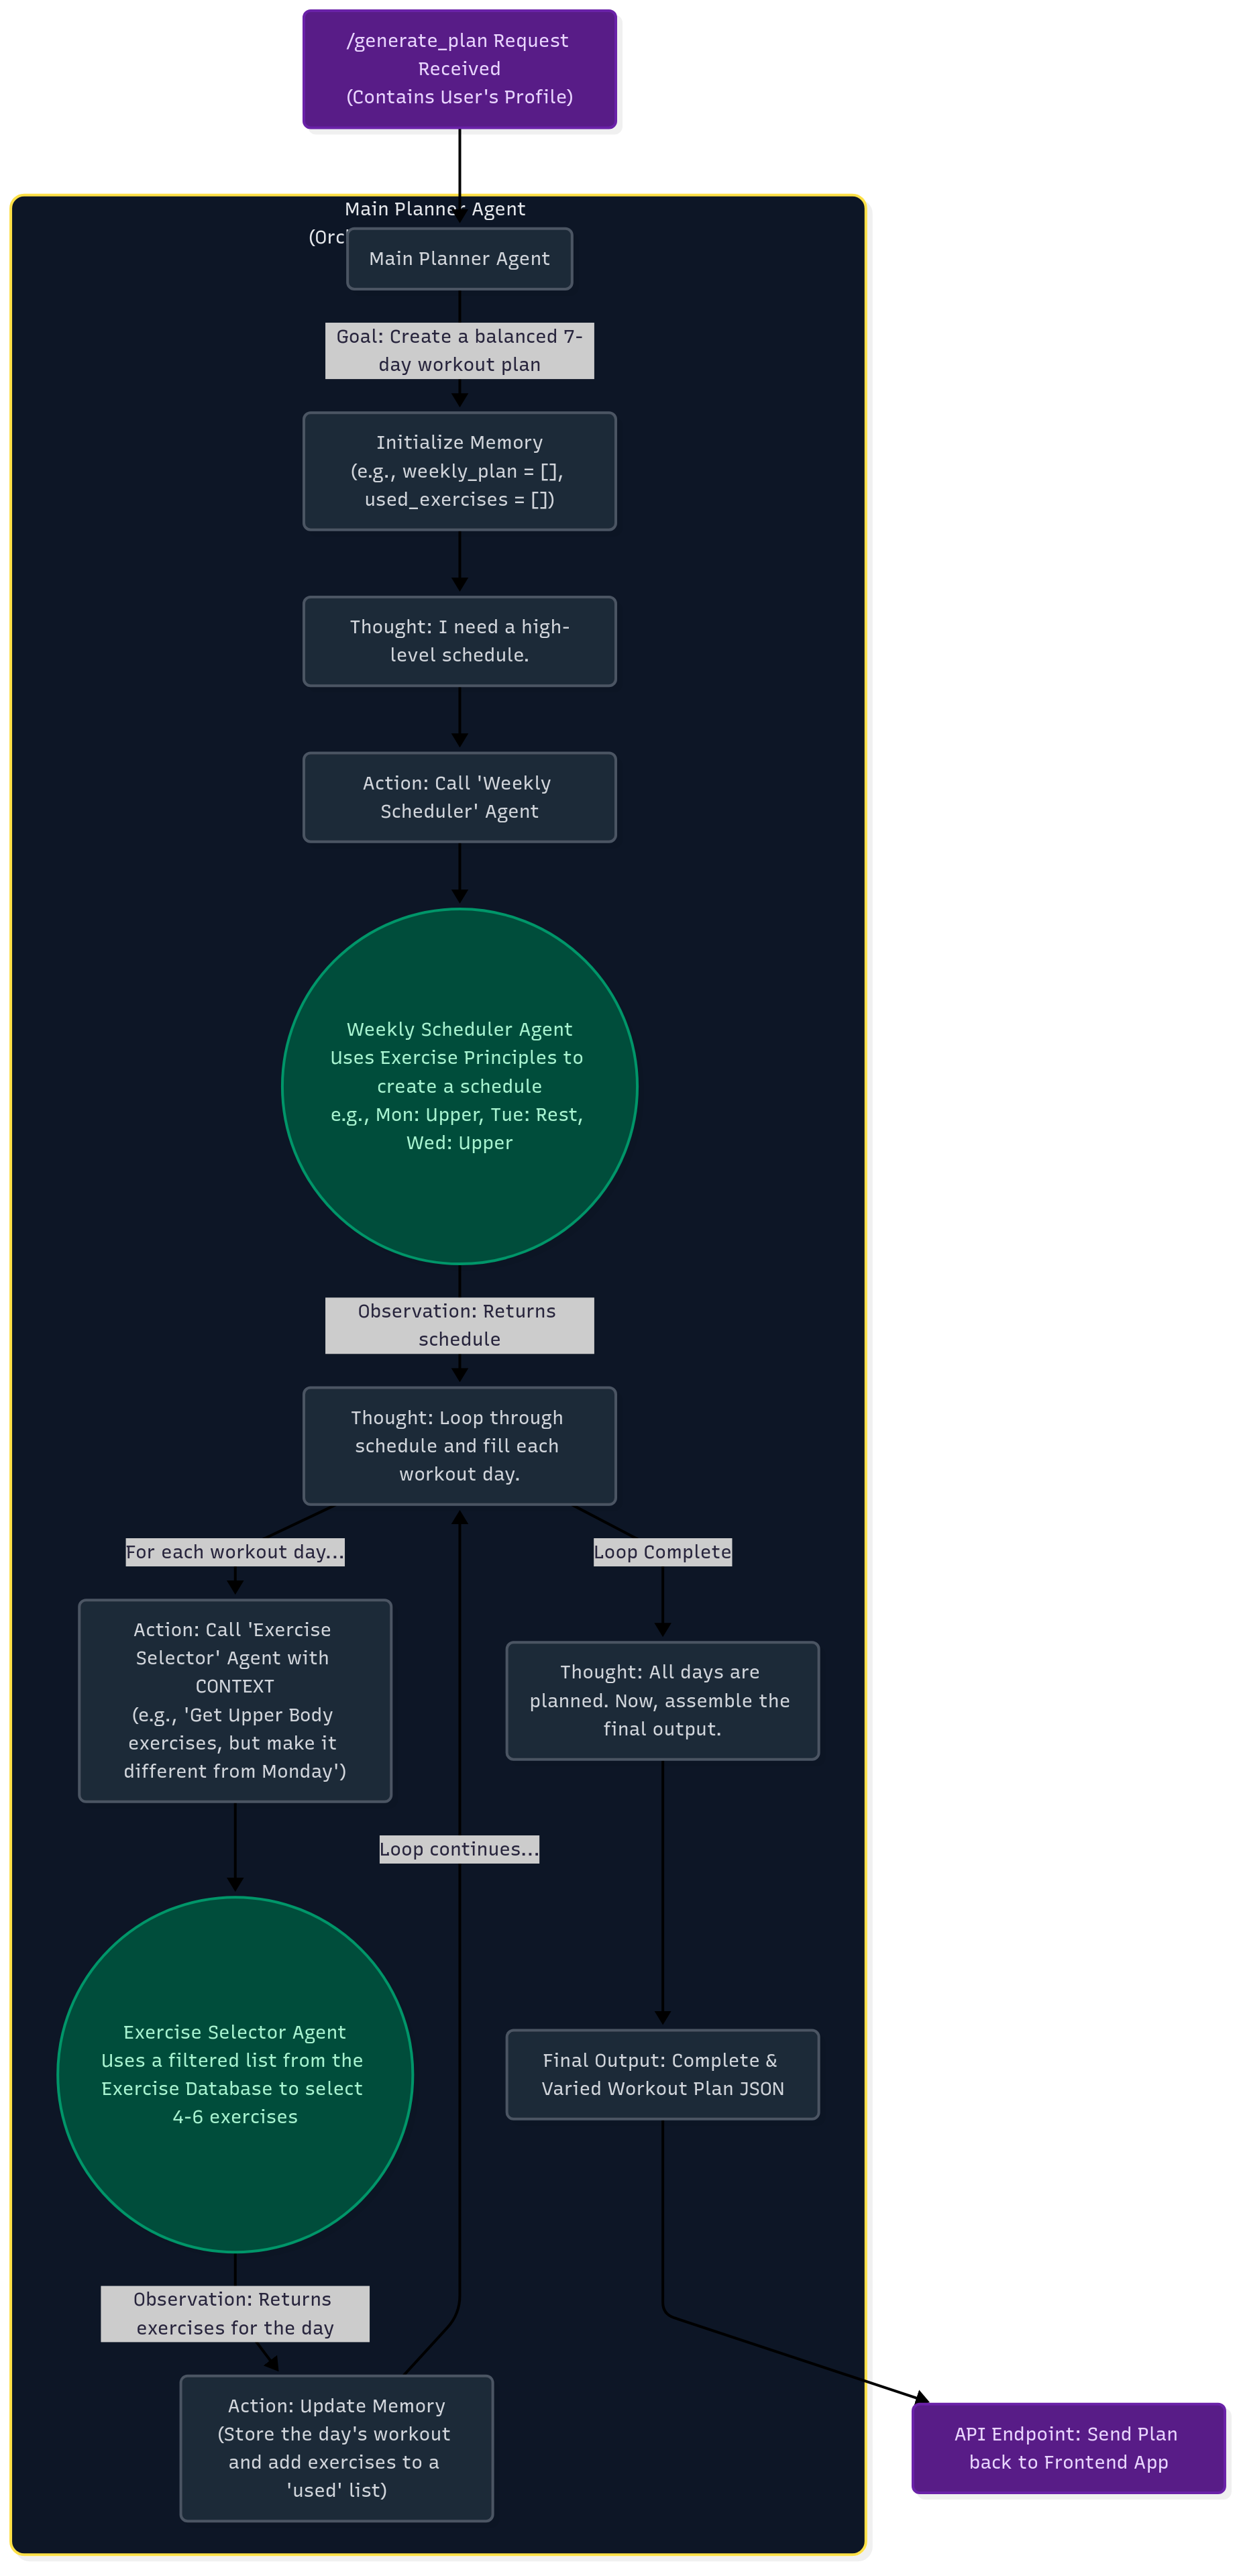

**Setup: Installing Library**

In [ ]:
# Installing the Google AI library
!pip install -q google-generativeai

print("✅ Installation complete. Ready for Cell 2 (API Key Configuration).")

✅ Installation complete. Ready for Cell 2 (API Key Configuration).


**API Configuration**

In [ ]:
import os
from google.colab import userdata
import google.generativeai as genai

try:
    # Get the API key from Colab's secret manager
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
    print("✅ API Key configured successfully! Ready for the next step.")
except userdata.SecretNotFoundError:
    print("🛑 Error: Secret 'GEMINI_API_KEY' not found.")
    print("Please follow the instructions in the comments to set up your API key.")
except Exception as e:
    print(f"An error occurred during configuration: {e}")

✅ API Key configured successfully! Ready for the next step.


**Building Profile analyzer tool. The onboarding worklow was able to ingest user data. This LLM based function will create a structured output for our Weekly scheduler agent to ultimately create a workout plan for the user**


In [ ]:
import json
# This is only the prompt builder
def build_analyzer_prompt(raw_data: dict) -> str:
    """Builds the detailed prompt for the Gemini model."""

    # Convert the raw data dictionary into a simple text block for the prompt
    user_input_text = ""
    for key, value in raw_data.items():
        user_input_text += f"- {key}: {value}\n"

    # This prompt is the "brain" of our analyzer. It gives the LLM its role,
    # instructions, and the required output format.
    prompt = f"""
    You are an expert fitness data analyst. Your task is to analyze the following user responses from an onboarding questionnaire and extract key information into a structured JSON format.

    Here is the user's input:
    ---
    {user_input_text}
    ---

    Follow these instructions precisely:
    1.  Analyze the 'goal' text. You MUST classify it into ONE of the following categories: ["muscle gain", "weight loss","fat Loss","weight gain" ,"endurance", "general fitness","other"].
    2.  Analyze the 'fitness_level' text. You MUST classify it into ONE of the following: ["beginner", "intermediate", "advanced"].
    3.  From 'availability_days' and 'availability_time', extract only the primary numerical value for each. If a time is given in hours, convert it to minutes (e.g., "1 hour" becomes 60).
    4.  From the 'equipment' text, create a list of all available equipment. Standardize the terms to a list containing any of the following that apply: ["bodyweight", "dumbbells", "barbell", "resistance_bands", "kettlebells", "gym_access"]. Always include "bodyweight".
    5.  From 'additional_notes', identify any potential physical limitations or constraints. Map them to a list containing any of the following that apply: ["avoid_high_impact_lower_body", "avoid_heavy_lifting_back", "avoid_overhead_press", "general_caution_left_foot", "general_caution_right_foot"].

    Your final output MUST be a single, valid JSON object and nothing else. Do not include any explanatory text or markdown formatting like ```json before or after the JSON object.

    The JSON object must have this exact structure:
    {{
      "analyzed_goal": "string",
      "analyzed_level": "string",
      "analyzed_availability": {{
        "days_per_week": integer,
        "time_per_session_minutes": integer
      }},
      "analyzed_equipment": ["string"],
      "analyzed_constraints": ["string"]
    }}
    """
    return prompt

def analyze_user_profile_with_llm(raw_data: dict) -> dict | None:
    """
    Analyzes raw user onboarding data using an LLM and returns a structured profile.
    """
    if not GEMINI_API_KEY:
        print("Cannot run LLM analysis: Gemini API Key is not configured.")
        return None

    # Use a model that is good at following instructions and specify JSON output.
    generation_config = {
        "temperature": 0.2, # Lower temperature for more predictable, structured output
        "response_mime_type": "application/json",
    }
    model = genai.GenerativeModel(
        model_name="gemini-1.5-flash", # A fast and capable model
        generation_config=generation_config
    )

    prompt = build_analyzer_prompt(raw_data)

    try:
        print("--- Sending prompt to Gemini for analysis... ---")
        response = model.generate_content(prompt)

        # The response text should be a valid JSON string
        json_output = response.text
        print("--- Received JSON output from Gemini. ---")

        # Parse the JSON string into a Python dictionary
        structured_profile = json.loads(json_output)

        # Include original data for reference if needed
        structured_profile["original_data"] = raw_data

        return structured_profile

    except Exception as e:
        print(f"An error occurred while analyzing profile with LLM: {e}")
        # Use getattr to safely access response.text in case response itself is an error
        print(f"LLM Raw Response (if available): {getattr(response, 'text', 'N/A')}")
        return None

print("✅ Profile Analyzer functions defined successfully.")


✅ Profile Analyzer functions defined successfully.


In [ ]:
# @title Testing out Profile analyzer function
# This is the raw data you would have collected from the onboarding chat
sample_user_data = {
    "goal": "Become stronger and more energetic, I want to increase muscle mass",
    "fitness_level": "Beginner, worked out a bit before",
    "availability_days": "5 Days",
    "availability_time": "1 Hour",
    "equipment": "BodyWeight, Dumbell, Full Gym",
    "additional_notes": "I have a weak left foot because of an ankle twist"
}

print("Analyzing sample user data...")
# The Main Planner Agent calls the LLM-based analyzer tool
analyzed_profile = analyze_user_profile_with_llm(sample_user_data)

# Print the final, structured output
if analyzed_profile:
    print("\n--- ✅ Structured Profile Generated by LLM ---")
    # Use json.dumps for pretty printing the dictionary
    print(json.dumps(analyzed_profile, indent=4))
else:
    print("\n--- 🛑 Failed to generate structured profile. Check previous errors. ---")


Analyzing sample user data...
--- Sending prompt to Gemini for analysis... ---
--- Received JSON output from Gemini. ---

--- ✅ Structured Profile Generated by LLM ---
{
    "analyzed_goal": "muscle gain",
    "analyzed_level": "beginner",
    "analyzed_availability": {
        "days_per_week": 5,
        "time_per_session_minutes": 60
    },
    "analyzed_equipment": [
        "bodyweight",
        "dumbbells",
        "gym_access"
    ],
    "analyzed_constraints": [
        "general_caution_left_foot"
    ],
    "original_data": {
        "goal": "Become stronger and more energetic, I want to increase muscle mass",
        "fitness_level": "Beginner, worked out a bit before",
        "availability_days": "5 Days",
        "availability_time": "1 Hour",
        "equipment": "BodyWeight, Dumbell, Full Gym",
        "additional_notes": "I have a weak left foot because of an ankle twist"
    }
}


**Once we have a structured output, we are ready for the next step. A weekly Planner Agent who plans which days of the week should be trained and which muscles to focus on.**


In [ ]:
# @title Define Agent Tool - The Exercise Principles
# This is our "rulebook". It's not an LLM call, but a simple function
# that provides foundational knowledge to guide the AI agents.

def get_exercise_principles() -> str:
    """
    Returns a string containing core, evidence-based exercise principles.
    This acts as a knowledge base for the AI agents.
    """
    principles = """
    - Principle of Specificity: The workout plan must be specific to the user's primary goal.
      - For 'muscle_gain', focus on resistance training with splits like 'Upper/Lower' or 'Full Body'.
      - For 'weight_loss', combine resistance training with cardiovascular exercise.
      - For 'endurance', prioritize cardiovascular exercise with some supplemental strength work.
      - For 'general_fitness', create a balanced mix of strength, cardio, and flexibility.
    - Principle of Recovery: Adequate rest is crucial for progress and injury prevention.
      - Do not schedule high-intensity resistance training for the same major muscle group (e.g., 'Upper Body', 'Lower Body') on consecutive days.
      - Ensure at least 1-2 full 'Rest' days per week. More for beginners.
      - 'Active Recovery' days (e.g., light walking, stretching, yoga) can be scheduled between intense workouts.
    - Principle of Balance: A plan should be well-rounded.
      - If using an 'Upper/Lower' split, ensure there's a balance between the two.
      - 'Full Body' routines are excellent for beginners or those with limited days per week (2-3 days).
    - Beginner Considerations: Users at the 'beginner' level should not be overwhelmed.
      - Prefer 2-3 workout days per week.
      - 'Full Body' routines are often the most effective starting point.
    - Workout Focus Types: The 'focus' for each day should be one of the following: ["Upper Body", "Lower Body", "Push", "Pull", "Legs", "Full Body", "Cardio", "Cardio & Core", "Active Recovery", "Rest"].
    """
    return principles


In [ ]:

# @title  Define Agent - The Weekly Scheduler
# This cell defines the functions for our Weekly Scheduler agent.
# Its job is to take the structured profile and, guided by the exercise principles,
# create a high-level 7-day schedule of workout focuses.

def build_scheduler_prompt(structured_profile: dict, principles: str) -> str:
    """Builds the prompt for the Weekly Scheduler agent."""

    # Create a text summary of the user's profile to feed into the prompt
    profile_summary = f"""
    - Goal: {structured_profile.get('analyzed_goal')}
    - Level: {structured_profile.get('analyzed_level')}
    - Days Per Week: {structured_profile.get('analyzed_availability', {}).get('days_per_week')}
    """

    prompt = f"""
    You are an expert fitness program scheduler. Your task is to create a logical and effective 7-day workout schedule based on the user's profile and fundamental exercise principles.

    USER PROFILE:
    ---
    {profile_summary}
    ---

    You MUST adhere to these EXERCISE PRINCIPLES:
    ---
    {principles}
    ---

    Your task:
    1.  Create a 7-day schedule starting from Monday.
    2.  Assign a 'focus' for each day based on the user's profile and the provided principles. The number of workout days MUST match the user's 'Days Per Week'.
    3.  The remaining days must be assigned as 'Rest' or 'Active Recovery'.
    4.  Ensure the schedule is logical (e.g., don't place two 'Upper Body' days back-to-back).

    Your final output MUST be a single, valid JSON object and nothing else.
    The JSON object must have a single root key "weeklySchedule".
    The value should be an array of 7 objects, each with a "day" and a "focus".

    Example Structure:
    {{
      "weeklySchedule": [
        {{ "day": "Monday", "focus": "Upper Body" }},
        {{ "day": "Tuesday", "focus": "Lower Body" }},
        {{ "day": "Wednesday", "focus": "Rest" }},
        {{ "day": "Thursday", "focus": "Upper Body" }},
        {{ "day": "Friday", "focus": "Lower Body" }},
        {{ "day": "Saturday", "focus": "Active Recovery" }},
        {{ "day": "Sunday", "focus": "Rest" }}
      ]
    }}
    """
    return prompt

def generate_weekly_schedule_with_llm(structured_profile: dict) -> dict | None:
    """
    Calls the LLM to generate a weekly schedule. This function represents
    the "Weekly Scheduler Agent".
    """
    if not GEMINI_API_KEY:
        print("Cannot run LLM scheduler: Gemini API Key is not configured.")
        return None

    # This agent can use a more powerful model if needed, but flash is often sufficient.
    generation_config = {
        "temperature": 0.3,
        "response_mime_type": "application/json",
    }
    model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=generation_config
    )

    # 1. Agent's first action: Get the principles (its "knowledge").
    principles = get_exercise_principles()

    # 2. Agent's second action: Build the prompt using the profile and principles.
    prompt = build_scheduler_prompt(structured_profile, principles)

    try:
        print("--- Sending prompt to Gemini for weekly schedule generation... ---")
        response = model.generate_content(prompt)

        json_output = response.text
        print("--- Received JSON schedule from Gemini. ---")

        schedule = json.loads(json_output)
        return schedule

    except Exception as e:
        print(f"An error occurred while generating the schedule with LLM: {e}")
        print(f"LLM Raw Response (if available): {getattr(response, 'text', 'N/A')}")
        return None

print("✅ Weekly Scheduler Agent defined successfully.")


✅ Weekly Scheduler Agent defined successfully.


In [ ]:

# @title Execute the Weekly Scheduler Test
# This cell tests our new agent. It uses the 'analyzed_profile' created by our first tool as input

print("Generating weekly schedule based on the analyzed profile...")

# The Main Planner Agent calls the Weekly Scheduler Agent with the structured profile
weekly_schedule = generate_weekly_schedule_with_llm(analyzed_profile)

if weekly_schedule:
    print("\n--- ✅ Weekly Schedule Generated by LLM ---")
    print(json.dumps(weekly_schedule, indent=4))
else:
    print("\n--- 🛑 Failed to generate weekly schedule. Check previous errors. ---")


Generating weekly schedule based on the analyzed profile...
--- Sending prompt to Gemini for weekly schedule generation... ---
--- Received JSON schedule from Gemini. ---

--- ✅ Weekly Schedule Generated by LLM ---
{
    "weeklySchedule": [
        {
            "day": "Monday",
            "focus": "Full Body"
        },
        {
            "day": "Tuesday",
            "focus": "Active Recovery"
        },
        {
            "day": "Wednesday",
            "focus": "Full Body"
        },
        {
            "day": "Thursday",
            "focus": "Rest"
        },
        {
            "day": "Friday",
            "focus": "Full Body"
        },
        {
            "day": "Saturday",
            "focus": "Cardio & Core"
        },
        {
            "day": "Sunday",
            "focus": "Rest"
        }
    ]
}


In [ ]:
# @title Upload Workout Database
import gspread
import pandas as pd
from google.auth import default
from google.colab import auth
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_key('1Q4Zduc5jXkkCimyYpkH--_olsoJbVpHCSy6fJNwy9FA')
worksheet = spreadsheet.get_worksheet(0)
workout_dataset = pd.DataFrame(worksheet.get("A1:G137"))
# Code for making the first row as header. Remove if not needed.
workout_dataset.columns = workout_dataset.iloc[0]
workout_dataset = workout_dataset.drop(0)
workout_dataset.head()

,name,description,focus,muscles_targeted,equipment,difficulty,constraints_to_avoid
1,Push-up,A classic bodyweight exercise pushing the body...,"Upper Body,Push,Chest,Full Body","Pectorals,Deltoids,Triceps,Core",bodyweight,intermediate,None
2,Incline Push-up,"A push-up with hands elevated on a surface, ma...","Upper Body,Push,Chest,Full Body","Lower Pectorals,Deltoids,Triceps","bodyweight,bench",beginner,avoid_overhead_press
3,Decline Push-up,"A push-up with feet elevated, increasing the d...","Upper Body,Push,Chest","Upper Pectorals,Deltoids,Triceps","bodyweight,bench",advanced,None
4,Knee Push-up,"A modified push-up performed on the knees, red...","Upper Body,Push,Chest,Full Body","Pectorals,Deltoids,Triceps",bodyweight,beginner,None
5,Diamond Push-up,A close-grip push-up variation that heavily ta...,"Upper Body,Push,Triceps","Triceps,Pectorals,Deltoids",bodyweight,advanced,None


In [ ]:
# @title  Prepare DataFrame and Define Search Tool
# This cell prepares the workout_dataset DataFrame by cleaning the data
# and then defines the core search function for our agent.
import numpy as np # Often useful with pandas

# --- Step 1: Data Preparation ---
# We need to clean the columns that contain comma-separated text into actual Python lists.
# This makes them searchable.

def clean_and_prepare_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the specified columns of the DataFrame, converting comma-separated
    strings into lists of strings.
    """
    print("--- Preparing DataFrame for searching... ---")

    # Make a copy to avoid modifying the original DataFrame if it's used elsewhere
    df_prepared = dataframe.copy()

    # List of columns that need to be converted from strings to lists
    columns_to_split = ['focus', 'equipment', 'constraints_to_avoid']

    for column in columns_to_split:
        # Fill empty cells with an empty string to prevent errors
        df_prepared[column] = df_prepared[column].fillna('')
        # Apply a lambda function to split the string by comma and strip whitespace
        df_prepared[column] = df_prepared[column].apply(
            lambda x: [item.strip() for item in x.split(',')] if x else []
        )

    print("--- DataFrame prepared. ---")
    return df_prepared

# --- Step 2: Create the Search Function (The "Tool") ---

def find_exercises_from_dataframe(
    prepared_dataframe: pd.DataFrame,
    day_focus: str,
    user_equipment: list,
    user_difficulty: str,
    user_constraints: list
) -> list:
    """
    This is the "Exercise Database Tool". It searches the prepared DataFrame
    to find suitable exercises based on the provided criteria.
    """
    print(f"\n--- Searching for exercises with Focus='{day_focus}' ---")

    # Start with the full prepared dataframe
    filtered_df = prepared_dataframe

    # 1. Filter by Difficulty
    # Select rows where the 'difficulty' column matches the user's level
    filtered_df = filtered_df[filtered_df['difficulty'].str.lower() == user_difficulty.lower()]
    print(f"Found {len(filtered_df)} exercises matching difficulty: '{user_difficulty}'")

    # 2. Filter by Focus
    # Select rows where the `day_focus` is present in the exercise's `focus` list
    filtered_df = filtered_df[filtered_df['focus'].apply(lambda focus_list: day_focus in focus_list)]
    print(f"Found {len(filtered_df)} exercises matching focus: '{day_focus}'")

    # 3. Filter by Equipment
    # An exercise is valid if the user has ALL the equipment it requires.
    # Note: We assume 'bodyweight' is always available.
    user_equipment_set = set(user_equipment + ['bodyweight'])
    filtered_df = filtered_df[filtered_df['equipment'].apply(lambda required_list: set(required_list).issubset(user_equipment_set))]
    print(f"Found {len(filtered_df)} exercises matching equipment list: {user_equipment}")

    # 4. Filter by Constraints
    # Exclude any exercise that has a constraint the user also has.
    user_constraints_set = set(user_constraints)
    if user_constraints_set: # Only apply this filter if the user has constraints
        filtered_df = filtered_df[filtered_df['constraints_to_avoid'].apply(lambda constraint_list: not user_constraints_set.intersection(set(constraint_list)))]
    print(f"Found {len(filtered_df)} exercises after applying user constraints.")

    # Convert the final filtered DataFrame to a list of dictionaries
    suitable_exercises = filtered_df.to_dict('records')

    return suitable_exercises


# --- Execute the preparation step ---
# This creates a new, cleaned DataFrame that we will use for all our searches.
# We assume 'workout_dataset' DataFrame exists from the previous cell.
if 'workout_dataset' in locals():
    prepared_workout_df = clean_and_prepare_dataframe(workout_dataset)
    print(f"\n✅ Exercise Database Tool is ready to use with {len(prepared_workout_df)} cleaned exercises.")
else:
    print("🛑 'workout_dataset' not found. Please run the previous cell to load the data from Google Sheets first.")

--- Preparing DataFrame for searching... ---
--- DataFrame prepared. ---

✅ Exercise Database Tool is ready to use with 136 cleaned exercises.


In [ ]:
# @title  Test the Exercise Database Tool

# Define a sample user profile (this would come from your Profile Analyzer agent)
sample_profile_for_search = {
  "analyzed_level": "beginner",
  "analyzed_equipment": ["bodyweight", "dumbbells"],
  "analyzed_constraints": ["avoid_high_impact_lower_body"]
}

# Define the focus for the day (this would come from your Weekly Scheduler agent)
sample_day_focus = "Full Body"

# --- Call the tool ---
suitable_exercises = find_exercises_from_dataframe(
    prepared_dataframe=prepared_workout_df,
    day_focus=sample_day_focus,
    user_equipment=sample_profile_for_search["analyzed_equipment"],
    user_difficulty=sample_profile_for_search["analyzed_level"],
    user_constraints=sample_profile_for_search["analyzed_constraints"]
)

# --- View the results ---
print(f"\n--- ✅ Found {len(suitable_exercises)} suitable exercises for a '{sample_day_focus}' day ---")

# Pretty print the list of exercises found
import json
print(json.dumps(suitable_exercises, indent=2))


--- Searching for exercises with Focus='Full Body' ---
Found 45 exercises matching difficulty: 'beginner'
Found 5 exercises matching focus: 'Full Body'
Found 4 exercises matching equipment list: ['bodyweight', 'dumbbells']
Found 3 exercises after applying user constraints.

--- ✅ Found 3 suitable exercises for a 'Full Body' day ---
[
  {
    "name": "Knee Push-up",
    "description": "A modified push-up performed on the knees, reducing the overall weight being lifted.",
    "focus": [
      "Upper Body",
      "Push",
      "Chest",
      "Full Body"
    ],
    "muscles_targeted": "Pectorals,Deltoids,Triceps",
    "equipment": [
      "bodyweight"
    ],
    "difficulty": "beginner",
    "constraints_to_avoid": []
  },
  {
    "name": "Bodyweight Squat",
    "description": "The fundamental lower body exercise, squatting down as if sitting in a chair.",
    "focus": [
      "Legs",
      "Quads",
      "Glutes",
      "Full Body"
    ],
    "muscles_targeted": "Quadriceps,Glutes,Hamstr

In [ ]:
# @title  Define the Exercise Selector Agent
# This agent's job is to create a balanced workout for a single day.
# It uses our rule-based search tool first, then uses an LLM for the final, intelligent selection.

def build_selector_prompt_from_shortlist(
    structured_profile: dict,
    day_focus: str,
    exercise_shortlist_text: str,
    previously_used_exercises: list[str]
) -> str:
    """Builds a focused prompt for the Exercise Selector agent using a pre-filtered list."""

    profile_summary = f"""
    - User's Goal: {structured_profile.get('analyzed_goal')}
    - User's Fitness Level: {structured_profile.get('analyzed_level')}
    """

    # This instruction for variety is only added if there are exercises to avoid
    variety_instruction = ""
    if previously_used_exercises:
        variety_instruction = f"""
    IMPORTANT: To ensure the weekly plan is varied and engaging, you should prioritize exercises the user has NOT done yet this week.
    Here is the list of exercises already scheduled this week to avoid if possible: {previously_used_exercises}
    It is acceptable to repeat one or two foundational exercises (like a main squat or press) if necessary for the plan's quality, but the overall workout must feel fresh.
    """

    prompt = f"""
    You are an expert personal trainer. Your task is to build a balanced, effective workout for a single day from a pre-approved list of exercises.

    USER PROFILE:
    ---
    {profile_summary}
    ---

    DAY'S FOCUS: "{day_focus}"

    {variety_instruction}

    PRE-APPROVED EXERCISE SHORTLIST (You MUST only choose from this list. Do not invent any exercises.):
    ---
    {exercise_shortlist_text}
    ---

    Your task:
    1.  From the 'PRE-APPROVED EXERCISE SHORTLIST', select a balanced set of 4 to 6 exercises that are perfect for the user's profile and the day's focus.
    2.  Create a logical workout. For a "Full Body" day, try to include an upper body push, an upper body pull, and a lower body exercise. For "Upper Body", include both push and pull movements.
    3.  Assign appropriate sets and reps for each selected exercise based on the user's goal and fitness level. For 'muscle_gain', recommend sets in the 8-12 rep range. For 'endurance' or 'weight_loss', recommend sets in the 12-20 rep range.
    4.  The 'details' string should be formed based on the Fitness level and User Goals.


        Your final output MUST be a single, valid JSON object and nothing else.
    The JSON object must have a single root key "exercises".
    The value should be an array of exercise objects.

    Example Structure:
    {{
      "exercises": [
        {{ "name": "Dumbbell Bench Press","Sets: 3" ,"reps: 8-12","details": "Focus on going slow and controlled, especially on the way down." }},
        {{ "name": "Bicep Curls","Sets: 3" ,"reps: 8-12","details": "Squeeze the bicep at the top of the curl for a full second" }}
      ]
    }}



"""
    return prompt

def select_final_exercises_with_llm(
    structured_profile: dict,
    day_focus: str,
    previously_used_exercises: list[str] # This context comes from the Main Planner
) -> dict | None:
    """
    Represents the "Exercise Selector Agent". It calls the LLM to select
    exercises from a pre-filtered list.
    """
    if not GEMINI_API_KEY:
        print("🛑 Cannot run LLM exercise selector: Gemini API Key is not configured.")
        return None

    # --- Step 1: Pre-filter with our rule-based tool ---
    exercise_shortlist = find_exercises_from_dataframe(
        prepared_dataframe=prepared_workout_df,
        day_focus=day_focus,
        user_equipment=structured_profile.get("analyzed_equipment", []),
        user_difficulty=structured_profile.get("analyzed_level", "beginner"),
        user_constraints=structured_profile.get("analyzed_constraints", [])
    )

    if not exercise_shortlist:
        print(f"--- No suitable exercises found in the database for focus: '{day_focus}'. Skipping LLM call. ---")
        return {"exercises": [{"name": f"No exercises found for '{day_focus}'", "details": "Please consider adding more exercises to the database."}]}

    # Convert the Python shortlist to a text format for the prompt
    exercise_shortlist_text = json.dumps(exercise_shortlist, indent=2)

    # --- Step 2: Use the LLM for intelligent selection ---
    generation_config = {
        "temperature": 0.5, # Allow some creativity in selection/combination
        "response_mime_type": "application/json",
    }
    model = genai.GenerativeModel(
        model_name="gemini-1.5-flash",
        generation_config=generation_config
    )

    # Build the prompt, now including the list of exercises to avoid
    prompt = build_selector_prompt_from_shortlist(
        structured_profile,
        day_focus,
        exercise_shortlist_text,
        previously_used_exercises
    )

    try:
        print(f"\n--- Sending shortlist to Gemini to select final exercises for '{day_focus}'... ---")
        response = model.generate_content(prompt)

        json_output = response.text
        print(f"--- Received final exercise list from Gemini. ---")

        final_exercises = json.loads(json_output)
        return final_exercises

    except Exception as e:
        print(f"🛑 An error occurred while generating final exercises: {e}")
        return None

print("✅ Exercise Selector Agent defined successfully. Ready to test.")

✅ Exercise Selector Agent defined successfully. Ready to test.


In [ ]:
# @title Test the Exercise Selector Agent
# Now we test our new, efficient agent. We'll give it the same profile
# as our previous test to see how it uses the pre-filtered shortlist
# to make its final selection.

# We will use the 'analyzed_profile' variable that was created by Cell 4.
# We also need a sample 'day_focus', which would normally come from the Weekly Scheduler.
sample_day_focus_for_selection = "Legs"

# For the first workout of the week, the list of used exercises is empty.
previously_used = []

# --- Call the Exercise Selector Agent ---
if 'analyzed_profile' not in locals() or 'prepared_workout_df' not in locals():
    print("🛑 Prerequisite data not found. Please run Cell 4 and Cell 9 successfully first.")
else:
    final_exercise_list = select_final_exercises_with_llm(
        structured_profile=analyzed_profile,
        day_focus=sample_day_focus_for_selection,
        previously_used_exercises=previously_used # Pass the empty list for now
    )

    # --- View the results ---
    if final_exercise_list:
        print(f"\n--- ✅ Final Exercise Selection for '{sample_day_focus_for_selection}' ---")
        print(json.dumps(final_exercise_list, indent=2))


--- Searching for exercises with Focus='Legs' ---
Found 45 exercises matching difficulty: 'beginner'
Found 5 exercises matching focus: 'Legs'
Found 5 exercises matching equipment list: ['bodyweight', 'dumbbells', 'gym_access']
Found 5 exercises after applying user constraints.

--- Sending shortlist to Gemini to select final exercises for 'Legs'... ---
--- Received final exercise list from Gemini. ---

--- ✅ Final Exercise Selection for 'Legs' ---
{
  "exercises": [
    {
      "name": "Bodyweight Squat",
      "Sets:": "3",
      "reps:": "8-12",
      "details": "Maintain proper form, focusing on controlled movements and full range of motion.  Prioritize quality over quantity."
    },
    {
      "name": "Leg Extension Machine",
      "Sets:": "3",
      "reps:": "8-12",
      "details": "Keep a steady pace and focus on the contraction of your quads at the top of the movement."
    },
    {
      "name": "Leg Curl Machine",
      "Sets:": "3",
      "reps:": "8-12",
      "details":

In [ ]:
# @title  Define the Main Planner Agent (Orchestrator)
# This is the master agent. It orchestrates the entire plan generation
# process by calling the other agents and tools in the correct sequence,
# maintaining a memory of used exercises to ensure variety.

def run_main_planner_agent(raw_user_data: dict) -> dict | None:
    """
    Orchestrates the entire workout plan generation process with memory.
    """
    print("--- 🤖 Main Planner Agent: Starting process... ---")

    # --- Step 1: Analyze the user's profile ---
    print("\n--- Step 1: Analyzing User Profile ---")
    structured_profile = analyze_user_profile_with_llm(raw_user_data)
    if not structured_profile:
        print("🛑 Main Planner Agent: Halting due to profile analysis failure.")
        return None
    print("--- Profile analysis complete. ---")
    # print(json.dumps(structured_profile, indent=2)) # Optional: uncomment to see the profile

    # --- Step 2: Generate the weekly schedule ---
    print("\n--- Step 2: Generating Weekly Schedule ---")
    schedule_data = generate_weekly_schedule_with_llm(structured_profile)
    if not schedule_data or "weeklySchedule" not in schedule_data:
        print("🛑 Main Planner Agent: Halting due to schedule generation failure.")
        return None
    print("--- Weekly schedule generated. ---")
    # print(json.dumps(schedule_data, indent=2)) # Optional: uncomment to see the schedule

    # --- Step 3: Initialize memory and loop through schedule to select exercises ---
    print("\n--- Step 3: Selecting Exercises for Each Workout Day ---")
    used_exercises_this_week = [] # The agent's memory
    final_plan_list = schedule_data["weeklySchedule"]

    for day_plan in final_plan_list:
        day_focus = day_plan.get("focus", "Rest")

        # Only select exercises for non-rest days
        if day_focus.lower() not in ["rest", "active recovery"]:
            # Call the Exercise Selector agent, passing the memory of used exercises
            exercise_list_data = select_final_exercises_with_llm(
                structured_profile=structured_profile,
                day_focus=day_focus,
                previously_used_exercises=used_exercises_this_week
            )

            if exercise_list_data and "exercises" in exercise_list_data:
                day_plan["exercises"] = exercise_list_data["exercises"]
                # Update memory with the names of the newly selected exercises
                for ex in exercise_list_data["exercises"]:
                    # Add to memory only if it's not already there (to be safe)
                    if ex.get("name") not in used_exercises_this_week:
                        used_exercises_this_week.append(ex.get("name"))
            else:
                # Handle cases where exercise selection fails for a specific day
                day_plan["exercises"] = [{"name": "Error generating exercises", "details": "Please try again."}]
        else:
            # For Rest or Active Recovery days, ensure the exercise list is empty
            day_plan["exercises"] = []

    print("--- Exercise selection complete. ---")

    # --- Step 4: Final Assembly ---
    final_output = {"weeklyPlan": final_plan_list}

    print("\n--- 🤖 Main Planner Agent: Process complete! ---")
    return final_output

print("✅ Main Planner Agent (Orchestrator) defined successfully. Ready to run the final test.")

✅ Main Planner Agent (Orchestrator) defined successfully. Ready to run the final test.


In [ ]:
# @title 🚀 Testing the entire flow!!🚀

sample_user_data = {'goal': 'Become stronger and more energetic, I want to increase muscle mass',
 'fitness_level': 'Beginner, worked out a bit before',
 'availability_days': '5 Days',
 'availability_time': '1 Hours',
 'equipment': 'GYM,BODYWEIGHT',
 'additional_notes': 'I have a weak left leg'}


In [ ]:
# @title Final  Test
# This cell simulates the API call to /generate_plan. It takes the raw
# user data and runs it through our complete agent-based system.



# We will use the 'sample_user_data' variable that was created in a previous cell.
if 'sample_user_data' not in locals():
    print("🛑 'sample_user_data' not found. Please run all the preceding setup cells successfully first.")
else:
    print("🚀🚀🚀 Starting the full workout plan generation process... 🚀🚀🚀")

    # This is the only input the main agent needs.
    final_workout_plan = run_main_planner_agent(sample_user_data)

    if final_workout_plan:
        print("\n\n--- 🎉✨ FINAL WORKOUT PLAN GENERATED ✨🎉 ---")
        print(json.dumps(final_workout_plan, indent=4))
    else:
        print("\n\n--- 🛑 FAILED to generate the final workout plan. Check logs in previous steps. ---")

🚀🚀🚀 Starting the full workout plan generation process... 🚀🚀🚀
--- 🤖 Main Planner Agent: Starting process... ---

--- Step 1: Analyzing User Profile ---
--- Sending prompt to Gemini for analysis... ---
--- Received JSON output from Gemini. ---
--- Profile analysis complete. ---

--- Step 2: Generating Weekly Schedule ---
--- Sending prompt to Gemini for weekly schedule generation... ---
--- Received JSON schedule from Gemini. ---
--- Weekly schedule generated. ---

--- Step 3: Selecting Exercises for Each Workout Day ---

--- Searching for exercises with Focus='Push' ---
Found 45 exercises matching difficulty: 'beginner'
Found 14 exercises matching focus: 'Push'
Found 7 exercises matching equipment list: ['bodyweight', 'gym_access']
Found 7 exercises after applying user constraints.

--- Sending shortlist to Gemini to select final exercises for 'Push'... ---
--- Received final exercise list from Gemini. ---

--- Searching for exercises with Focus='Pull' ---
Found 45 exercises matching di